In [1]:
import numpy as np
import math
from datascience import *
import datetime


# These lines set up the plotting functionality and formatting.
import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# The Dataset

Through this project, I hope to explore the NYC Gifted & Talented Scores from 2017-2018 & 2018-2019 (without regard to the year), and practice data cleaning on a messy but easy dataset. After cleaning the dataset, I would like to do some exploratory data analysis to see if there's any correlation between birth month and scores.


In [2]:
gt_201719 = Table.read_table('G&T Results 2017-19 (Responses) - Form Responses 1.csv')
gt_201719.show()

Timestamp,Entering Grade Level,District,Birth Month,OLSAT Verbal Score,OLSAT Verbal Percentile,NNAT Non Verbal Raw Score,NNAT Non Verbal Percentile,Overall Score,School Preferences,School Assigned,Will you enroll there?
4/8/2017 6:44,1,6,September,28,99,45,99,99,"NEST+m, TAG, Anderson, Q300",NEST,YES
4/7/2017 10:40,K,nan,August,25,99,39,99,99,"Anderson, NEST+m",nan,Maybe
4/7/2017 10:41,1,nan,March,27,96,42,99,98,nan,nan,Maybe
4/7/2017 10:43,K,nan,September,23,97,40,99,98,nan,nan,nan
4/10/2017 10:18,K,22,April,25,98,38,99,99,Brooklyn School of Inquiry,Currently - local Brooklyn dual language,Maybe
4/7/2017 11:03,K,nan,May,24,97,36,98,98,nan,nan,nan
4/7/2017 11:15,K,nan,February,26,99,42,99,99,Anderson NEST TAG Q300,nan,nan
4/7/2017 11:26,K,nan,October,24,99,42,99,99,"Nest+M, Anderson",nan,Yes
4/7/2017 11:31,1,nan,March,23,81,42,99,95,nan,nan,nan
4/7/2017 11:32,2,nan,April,29,99,44,99,99,Any citywide or district 3 school,nan,Yes


# Cleaning

I'll document step-by-step my thought process when working with this data

Immediately, I recognize that since I'm not considering the year, district, school preferences, school assigned, or enrollment plans, those columns are not of use to me. So my first step is to edit the current table by dropping those columns.

In [3]:
gt_201719 = gt_201719.drop("Timestamp", "District", "School Preferences", "School Assigned", "Will you enroll there?")
gt_201719.show()

Entering Grade Level,Birth Month,OLSAT Verbal Score,OLSAT Verbal Percentile,NNAT Non Verbal Raw Score,NNAT Non Verbal Percentile,Overall Score
1,September,28,99,45,99,99
K,August,25,99,39,99,99
1,March,27,96,42,99,98
K,September,23,97,40,99,98
K,April,25,98,38,99,99
K,May,24,97,36,98,98
K,February,26,99,42,99,99
K,October,24,99,42,99,99
1,March,23,81,42,99,95
2,April,29,99,44,99,99


The first column is "Entering Grade Level" The inconsistency of in this column is that some of the grades are written as '1st' or '2nd' instead of 'K', '1', '2', or '3' (the grades the Gifted & Talented testing takes place). I will be editing values such that every value that isn't 'K', '1', '2', or '3' becomes one of those 4 values, and then representing 'K' as 0. Also, since there are only 2 data points for Grade '3', I'll be removing those data points since it won't be helpful for my analysis.

In [4]:
grade = gt_201719.column(0)

In [5]:
for i in range(0, len(grade)):
    g = grade.item(i)
    if g == 'K':
        g = '0'
    if g != '0' or g != '1' or g != '2' or g != '3':
        g = g[0]
        grade[i] = g
gt_201719.with_columns("Entering Grade Level", grade)
gt_201719 = gt_201719.where("Entering Grade Level", are.contained_in(make_array('0', '1', '2')))
gt_201719.show()

Entering Grade Level,Birth Month,OLSAT Verbal Score,OLSAT Verbal Percentile,NNAT Non Verbal Raw Score,NNAT Non Verbal Percentile,Overall Score
1,September,28,99,45,99,99
0,August,25,99,39,99,99
1,March,27,96,42,99,98
0,September,23,97,40,99,98
0,April,25,98,38,99,99
0,May,24,97,36,98,98
0,February,26,99,42,99,99
0,October,24,99,42,99,99
1,March,23,81,42,99,95
2,April,29,99,44,99,99


Now I'm going to skip ahead to the "NNAT Non Verbal Percentile" column. At the end of the column I noticed a lot of the values say "Illinos" which does not make sense given the context of the column. However, I also realized that the NNAT Non Verbal percentile is fairly consistent, with mostly 99's. Thus, considering that the end goal is to check for any correlation between Birth Month and scores, having a column with mostly 99's does not provide enough distinction for any analysis. So I will be dropping the "NNAT Non Verbal Percentile" entirely, and for consistency in any analysis, I'll also drop the "OLSAT Verbal Percentile" column.
If I weren't dropping the column, I would have checked to see what the NNAT Non Verbal Raw Score was, and chosen the average percentile of the same scores occurring within that grade - in the case of this table, the percentile would likely have been 99.

In [6]:
gt_201719 = gt_201719.drop("NNAT Non Verbal Percentile", "OLSAT Verbal Percentile")
gt_201719.show()

Entering Grade Level,Birth Month,OLSAT Verbal Score,NNAT Non Verbal Raw Score,Overall Score
1,September,28,45,99
0,August,25,39,99
1,March,27,42,98
0,September,23,40,98
0,April,25,38,99
0,May,24,36,98
0,February,26,42,99
0,October,24,42,99
1,March,23,42,95
2,April,29,44,99


Now I'll be going through the "OLSAT Verbal Score" and "NNAT Non Verbal Raw Score" columns. The OLSAT Verbal Score and NNAT Non Verbal Raw Score are out of 30 and 48, respectively. First, for scores expressed as fractions, if the denominator is 30 and 48, respectively, then I will edit the value in that cell to be the numerator. Then, I will only keep rows where the values are between 0 and 31, excluding 31, for OLSAT and between 0 and 49, excluding 49, for NNAT.

In [7]:
def frac_handler(col, col_arr, denom_asstr):
    for i in range(0, len(col_arr)):
        c = col_arr.item(i) 
        if '/' in c and np.char.endswith(c, denom_asstr):
            c = c[0:2]
            col_arr[i] = c
    gt_201719.with_columns(col, col_arr)
    
olsat = gt_201719.column("OLSAT Verbal Score")
nnat = gt_201719.column("NNAT Non Verbal Raw Score")

frac_handler("OLSAT Verbal Score", olsat, '30')
frac_handler("NNAT Non Verbal Raw Score", nnat, '48')

In [8]:
olsat_range = (np.arange(0, 31)).astype(str)
nnat_range = (np.arange(0, 49)).astype(str)

gt_201719 = gt_201719.where("OLSAT Verbal Score", are.contained_in(olsat_range)).where("NNAT Non Verbal Raw Score", 
                                                                           are.contained_in(nnat_range))
gt_201719.show()

Entering Grade Level,Birth Month,OLSAT Verbal Score,NNAT Non Verbal Raw Score,Overall Score
1,September,28,45,99
0,August,25,39,99
1,March,27,42,98
0,September,23,40,98
0,April,25,38,99
0,May,24,36,98
0,February,26,42,99
0,October,24,42,99
1,March,23,42,95
2,April,29,44,99


The last column where there are still discrepancies in how the data is presented is the "Birth Month" column - some months are shown as the month name, while others are the month number. I plan to make all the months numerical representations so that it's easier to see a correlation between age (as represented by the birth month) and the test scores.

Before I work on that though, I am going to drop the "Overall Score" column, for the same reasoning as I dropped the Percentile columns - there simply isn't enough variation between scores, especially in comparison to the OLSAT Verbal Score and the NNAT Non Verbal Raw Score. I believe I'll have more distinct results if I want to explore the correlation between the birth month and scores, I believe I'll have more distinct results if the scores are the OLSAT and NNAT scores.

Since I plan to represent the Birth Month column numerically as well, I'm also going to make all of my columns integer arrays instead of string arrays.

In [9]:
gt_201719 = gt_201719.drop("Overall Score")

In [10]:
def int_arr_col(col_name):
    col = gt_201719.column(col_name)
    col_int = col.astype(int)
    return gt_201719.with_columns(col_name, col_int)

In [11]:
gt_201719 = int_arr_col("Entering Grade Level")
gt_201719 = int_arr_col("OLSAT Verbal Score")
gt_201719 = int_arr_col("NNAT Non Verbal Raw Score")
gt_201719.show()

Entering Grade Level,Birth Month,OLSAT Verbal Score,NNAT Non Verbal Raw Score
1,September,28,45
0,August,25,39
1,March,27,42
0,September,23,40
0,April,25,38
0,May,24,36
0,February,26,42
0,October,24,42
1,March,23,42
2,April,29,44


Now, time for the numerical representation of the Birth Months. Instead of equating "January" to 1, "February" to 2, etc., "September" will be 1, "October" will be 2.
This decision is motivated by the cutoff system. In New York, each Local Education Agency (i.e. each school/educational institution) gets to choose the age cutoff for incoming students. However, the general cutoff across the country, including NYC, is age 5 by September 1. Thus, most September babies enter kindergarten at age 6, making them the oldest students. As such, since I want to look for the correlation between age *as represented by the birth month* and scores, it makes more sense to represent "September" as 1. To do this, I imported **datetime**.
I'll also convert numbers (currently in String form) representing the month number in a calendar year to the month number (in int form) in my numerical representation.
Finally, I'll relabel "Birth Month" to "School Month" as a better label for the numerical representation of the months.

In [12]:
birth_month = gt_201719.column("Birth Month")
month_names = make_array("January", "February", "March", "April", "May", "June", "July", "August",
                        "September", "October", "November", "December")
month_nums = (np.arange(1, 13)).astype(str)
month_ints = make_array()

for m in birth_month:
    if m in month_names:
        datetime_object = datetime.datetime.strptime(m, "%B")
        month_number = datetime_object.month
        month_number = (month_number - 8) % 12
        if month_number == 0:
            month_number = 12
        month_ints = np.append(month_ints, month_number)
    if m in month_nums:
        month_number = m.astype(int)
        month_number = (month_number - 8) % 12
        if month_number == 0:
            month_number = 12
        month_ints = np.append(month_ints, month_number)
            
month_ints = month_ints.astype(int)
gt_201719 = gt_201719.with_column("Birth Month", month_ints).relabel("Birth Month", "School Month")
gt_201719.show()

Entering Grade Level,School Month,OLSAT Verbal Score,NNAT Non Verbal Raw Score
1,1,28,45
0,12,25,39
1,7,27,42
0,1,23,40
0,8,25,38
0,9,24,36
0,6,26,42
0,2,24,42
1,7,23,42
2,8,29,44


Now the data is cleaned and in the format I'd like to perform my analysis!

# Exploratory Data Analysis: Linear Regression

First, I'm going to sort the table by month and grade so that the table is more organized. Then, using a scatter plot, I'm going to check for correlation by grade between the month and OLSAT score, and the month and NNAT score.

In [40]:
gt_201719 = gt_201719.sort("School Month").sort("Entering Grade Level")
kinder = gt_201719.where("Entering Grade Level", 0)
first = gt_201719.where("Entering Grade Level", 1)
second = gt_201719.where("Entering Grade Level", 2)
first_second = gt_201719.where("Entering Grade Level", are.above(0))

First, let's check for any correlation between the month and the OLSAT score for kindergarten.

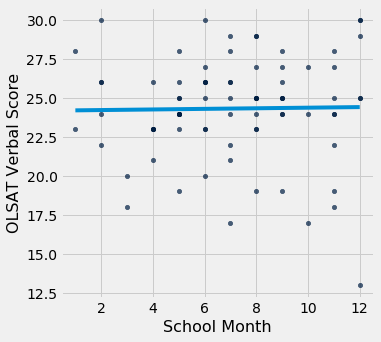

In [38]:
kinder.scatter("School Month", "OLSAT Verbal Score")
x = kinder.column("School Month")
y = kinder.column("OLSAT Verbal Score")
m, b = np.polyfit(x, y, 1)
plots.plot(x, m*x + b)

My hypothesis was that the oldest kids in kindergarten had higher OLSAT Verbal Scores, and there would be a negative correlation. However, as we can see, there is no correlation.

Let's check for any correlation between the month and the NNAT score for kindergarten.

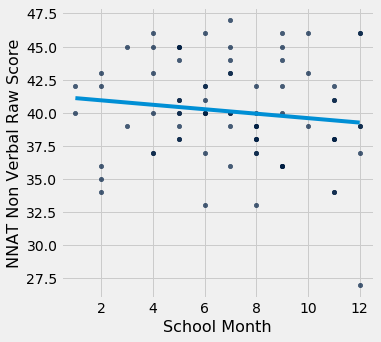

In [39]:
kinder.scatter("School Month", "NNAT Non Verbal Raw Score")
x = kinder.column("School Month")
y = kinder.column("NNAT Non Verbal Raw Score")
m, b = np.polyfit(x, y, 1)
plots.plot(x, m*x + b)

Interestingly enough, there is a weak negative correlation, so the older kids in kindergarten have slightly higher NNAT Non Verbal Raw Scores.

Perhaps, as students get more acclimated to the school system, there is a stronger negative association. Let's check if there's any correlation between the month and the OLSAT score for 1st and 2nd grade.

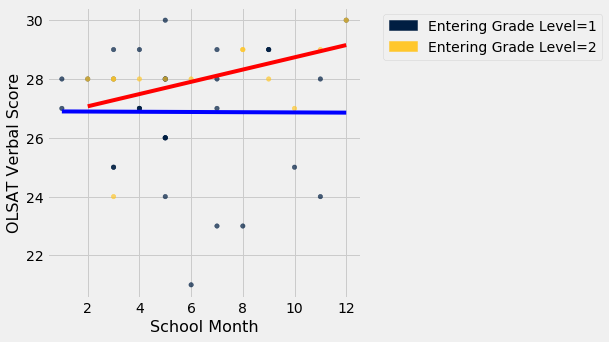

In [44]:
first_second.scatter("School Month", "OLSAT Verbal Score", group = "Entering Grade Level")

x1 = first.column("School Month")
y1 = first.column("OLSAT Verbal Score")
m1, b1 = np.polyfit(x1, y1, 1)
plots.plot(x1, m1*x1 + b1, 'b') # the blue line is the linear regression for first grade

x2 = second.column("School Month")
y2 = second.column("OLSAT Verbal Score")
m2, b2 = np.polyfit(x2, y2, 1)
plots.plot(x2, m2*x2 + b2, 'r') # the red line is the linear regression for second grade

Interestingly enough, the correlation is the opposite of what I had hypothesized. While there is no correlation between month and OLSAT Verbal scores for first grade students, there is a **positive** correlation between month and OLSAT Verbal scores for second grade students. Meaning, the younger students actually have higher OLSAT Verbal scores.
I do want to point out that there is an outlier in grade one, born in February and with an OLSAT Verbal score less than 22. This could have skewed the linear regression to have less correlation, instead of what seems like would be a negative correlation.

Let's check if there's any correlation between month and NNAT scores.

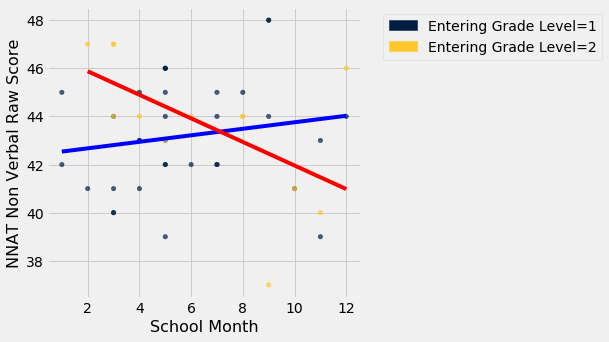

In [45]:
first_second.scatter("School Month", "NNAT Non Verbal Raw Score", group = "Entering Grade Level")

x1 = first.column("School Month")
y1 = first.column("NNAT Non Verbal Raw Score")
m1, b1 = np.polyfit(x1, y1, 1)
plots.plot(x1, m1*x1 + b1, 'b') # the blue line is the linear regression for first grade

x2 = second.column("School Month")
y2 = second.column("NNAT Non Verbal Raw Score")
m2, b2 = np.polyfit(x2, y2, 1)
plots.plot(x2, m2*x2 + b2, 'r') # the red line is the linear regression for second grade

The correlations have completely flipped between the OLSAT Verbal Scores and the NNAT Non Verbal Raw Scores.
There is a slight positive correlation between month and NNAT Non Verbal Raw scores for first grade students, meaning that the younger students have slightly higher NNAT Non Verbal Scores. However, for the second grade students, there is a very strong negative correlation, meaning the older students have higher NNAT Non Verbal scores.
I do want to point out that there is an outlier in grade two, born in May and with an NNAT Non Verbal Raw score less than 38. This could have skewed the linear regression to have a stronger correlation.

# Final Thoughts

I find this analysis really interesting because of the numerous articles, whether scholarly or editorial, written on the topic of whether students should start school earlier or later. Some examples of such articles are:
https://www.frbsf.org/economic-research/publications/economic-letter/2008/august/kindergarten-entry-age-achievement-gap/
https://www.seattleschild.com/what-happens-when-your-child-is-the-oldest-or-youngest-in-their-kindergarten-class/
https://childrensmd.org/browse-by-age-group/kindergarten-cut-dates-red-shirt-child-push-ahead/

I myself was born at the tail end of August, so I was always one of the younger students (though the cutoff was in December when I entered kindergarten vs September). My sister, born in January, "missed out" on a year of school and turned 6 in kindergarten. Anecdotally, our experiences were the opposite of my inferences. My sister was much more socially adept and excelled better and verbal communication, whereas non verbal communication was easier for me to show my understanding.

Of course, I can't make any conclusive statements with my analysis, but I would like end this project by making some inferences regarding the different scores and their correlation to the months (representing age).

The OLSAT Verbal test seems to indicate how well a student can *communicate* patterns ideas, whereas the NNAT Non Verbal relies on how well a student can *detect* different patterns and ideas.
Since younger students have to work with older students, I infer that as the years go by they become stronger at verbally communicating their ideas because they need those verbal skills to socialize with older students.
However, since older students have probably spent more time practicing their reading and writing skills, either in preschool or at home in preparation for school, they are better at recognizing patterns in written form and showcasing their understanding non verbally as well.

I myself was born at the tail end of August, so I was always one of the younger students (though the cutoff was in December when I entered kindergarten vs September). My sister, born in January, "missed out" on a year of school and turned 6 in kindergarten. Anecdotally, our experiences were the opposite of my inferences. My sister was much more socially adept and excelled better and verbal communication, whereas non verbal communication was easier for me to show my understanding.

Ultimately, the research on this topic also seems to be very split, which goes to show that the development of each child is truly unique.